Simulating Alpha = 0.0001...
Simulating Alpha = 0.001...
Simulating Alpha = 0.01...


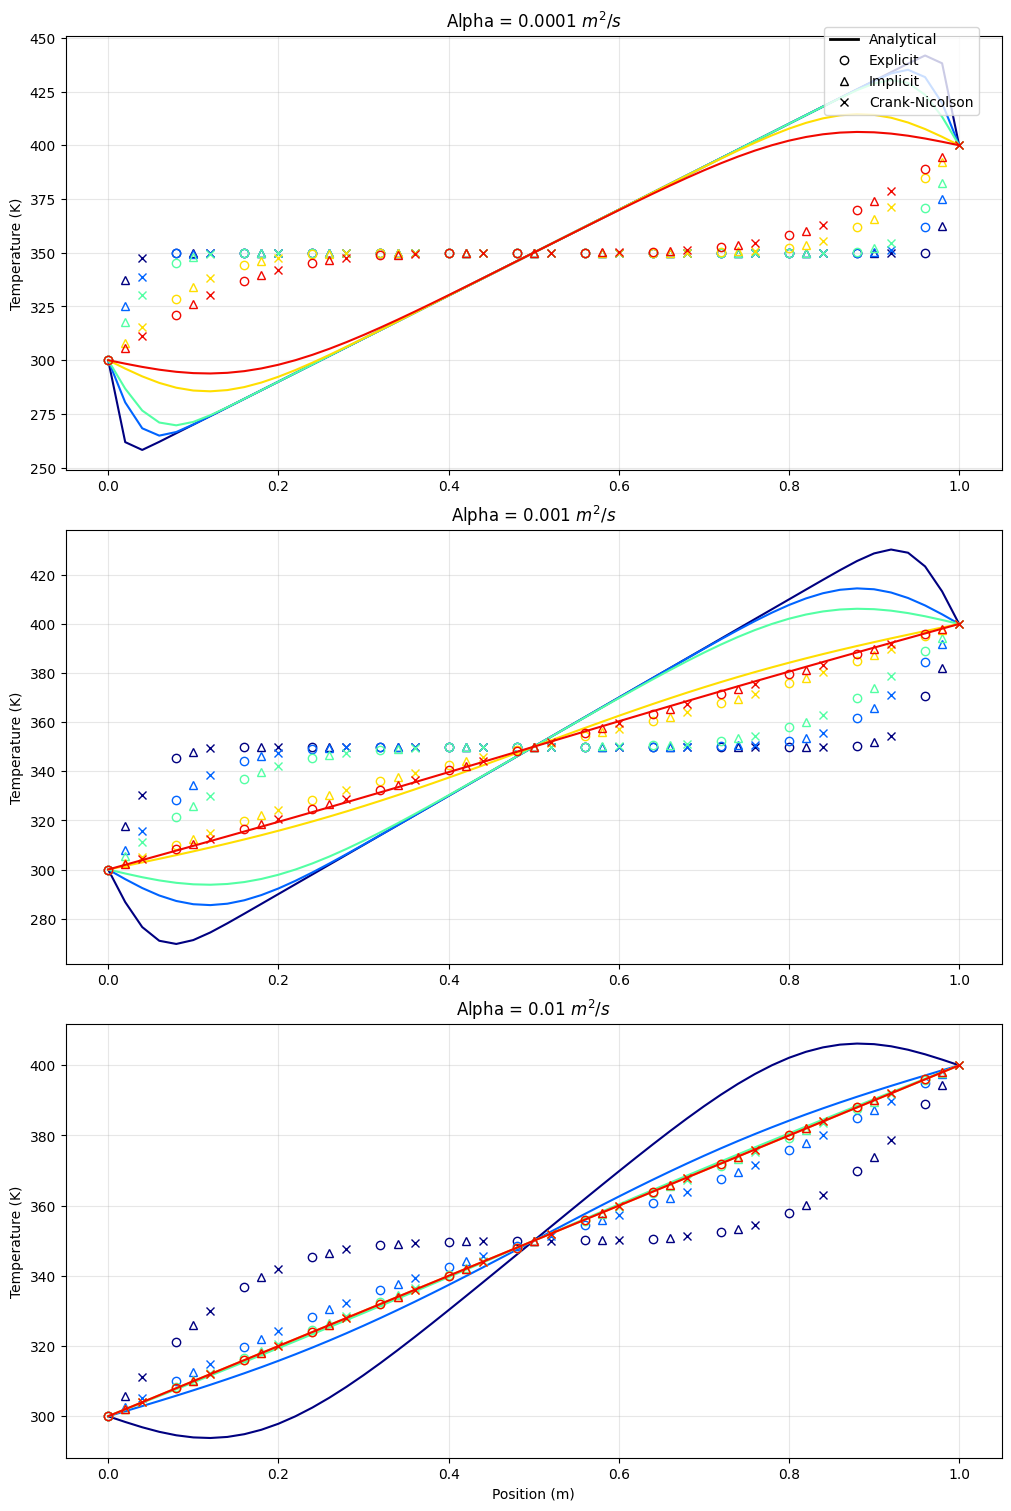

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import splu

class HeatSlabSolver:
    def __init__(self, L=1.0, nx=51, alpha=1.0, t_init=350.0, t_left=300.0, t_right=400.0):
        """
        Initialize the 1D Heat Slab problem parameters.
        """
        # Physics & Geometry
        self.L = L
        self.alpha = alpha
        self.T_init = float(t_init)  # Ensure float
        self.T_left = float(t_left)
        self.T_right = float(t_right)

        # Discretization
        self.nx = nx
        self.x = np.linspace(0, L, nx)
        self.dx = self.x[1] - self.x[0]

        # Internal node count (for linear algebra systems)
        self.n_inner = nx - 2

    def analytical_solution(self, t, n_terms=100):
        """Computes the exact Fourier series solution at time t."""
        if t <= 0: return np.full_like(self.x, self.T_init)

        # 1. Steady State Solution (Linear gradient)
        T_steady = self.T_left + (self.T_right - self.T_left) * (self.x / self.L)

        # 2. Transient Deviation (Fourier Series)
        summation = np.zeros_like(self.x)
        for n in range(1, n_terms + 1):
            lambda_n = n * np.pi / self.L

            # Integral of Initial Condition deviation
            term_init = (self.T_init / lambda_n) * (1 - (-1)**n)
            term_bc   = (self.T_left - (-1)**n * self.T_right) / lambda_n
            Bn = term_init - term_bc

            summation += Bn * np.sin(lambda_n * self.x) * np.exp(-self.alpha * lambda_n**2 * t)

        return T_steady - (2/self.L) * summation

    def _build_matrices(self, r, scheme):
        """Helper to construct sparse matrices for time-stepping."""
        I = sparse.eye(self.n_inner, format='csc')
        # Second derivative operator (central difference)
        diagonals = [np.ones(self.n_inner-1), -2*np.ones(self.n_inner), np.ones(self.n_inner-1)]
        D2 = sparse.diags(diagonals, [-1, 0, 1], format='csc')

        if scheme == 'implicit':
            # (I - r*D2) * T_new = T_old
            A = I - r * D2
            return A, None

        elif scheme == 'cn':
            # (I - 0.5*r*D2) * T_new = (I + 0.5*r*D2) * T_old
            A = I - 0.5 * r * D2
            B = I + 0.5 * r * D2
            return A, B
        return None, None

    def solve(self, scheme, dt, target_times):
        """
        Main solver method.
        scheme: 'explicit', 'implicit', 'cn'
        """
        # --- FIX IS HERE: dtype=np.float64 ---
        T = np.full(self.nx, self.T_init, dtype=np.float64)
        T[0], T[-1] = self.T_left, self.T_right

        r = self.alpha * dt / self.dx**2

        # Slightly increase steps to ensure we cover the last target time
        nt = int(max(target_times) / dt) + 10

        # Prepare storage
        results = {}
        # Map target times to specific step numbers
        target_indices = [int(t/dt) for t in target_times]

        # Pre-compute matrices for Implicit/CN
        solve_A = None
        B = None
        if scheme in ['implicit', 'cn']:
            A_mat, B_mat = self._build_matrices(r, scheme)
            solve_A = splu(A_mat).solve  # Pre-factorize for speed
            B = B_mat

        # Time Stepping Loop
        for n in range(1, nt + 1):

            if scheme == 'explicit':
                # T[i] = T[i] + r*(T[i+1] - 2T[i] + T[i-1])
                # Using temp array to avoid overwriting while reading
                T_new_inner = T[1:-1] + r * (T[2:] - 2*T[1:-1] + T[:-2])
                T[1:-1] = T_new_inner

            elif scheme == 'implicit':
                # RHS is T_old + boundary contributions
                b_vec = T[1:-1].copy()
                b_vec[0]  += r * self.T_left
                b_vec[-1] += r * self.T_right
                T[1:-1] = solve_A(b_vec)

            elif scheme == 'cn':
                # RHS is B*T_old + boundary contributions
                b_vec = B.dot(T[1:-1])
                b_vec[0]  += r * self.T_left
                b_vec[-1] += r * self.T_right
                T[1:-1] = solve_A(b_vec)

            # Store result if this step corresponds to a target time
            # We check closeness to handle floating point drift
            current_time = n * dt
            for t_targ in target_times:
                if abs(current_time - t_targ) < dt/1.5:
                    results[t_targ] = T.copy()

        return results

# --- Comparison & Plotting ---

def compare_schemes():
    # Configuration
    L = 1.0
    alphas = [0.0001, 0.001, 0.01]
    times = [1, 5, 10, 50, 100]

    # Create subplots
    fig, axes = plt.subplots(len(alphas), 1, figsize=(10, 15), constrained_layout=True)
    if len(alphas) == 1: axes = [axes]

    for ax, alpha in zip(axes, alphas):
        print(f"Simulating Alpha = {alpha}...")

        # Instantiate Solver
        solver = HeatSlabSolver(L=L, alpha=alpha, nx=51)

        # 1. Analytical Solution
        ana_res = {t: solver.analytical_solution(t) for t in times}

        # 2. Numerical Solutions
        # Explicit Stability Limit: dt <= 0.5 * dx^2 / alpha
        dt_stable = 0.5 * solver.dx**2 / alpha

        # Run solvers
        # Note: We use 90% of stable dt for explicit.
        # Implicit/CN are unconditionally stable, but we use the same dt for comparison.
        res_exp = solver.solve('explicit', dt=dt_stable * 0.9, target_times=times)
        res_imp = solver.solve('implicit', dt=dt_stable * 0.9, target_times=times)
        res_cn  = solver.solve('cn',       dt=dt_stable * 0.9, target_times=times)

        # Plotting
        colors = plt.cm.jet(np.linspace(0, 0.9, len(times)))

        for i, t in enumerate(times):
            if t not in res_exp: continue # Skip if time not reached

            c = colors[i]
            # Analytical (Line)
            ax.plot(solver.x, ana_res[t], color=c, linestyle='-', label=f't={t}s' if i==0 else "")

            # Explicit (Dots)
            ax.plot(solver.x[::4], res_exp[t][::4], 'o', color=c, fillstyle='none', markersize=6)

            # Implicit (Triangles)
            ax.plot(solver.x[1::4], res_imp[t][1::4], '^', color=c, fillstyle='none', markersize=6)

            # CN (Crosses)
            ax.plot(solver.x[2::4], res_cn[t][2::4], 'x', color=c, markersize=6)

        ax.set_title(f"Alpha = {alpha} $m^2/s$")
        ax.set_ylabel("Temperature (K)")
        ax.grid(True, alpha=0.3)
        if alpha == alphas[-1]: ax.set_xlabel("Position (m)")

    # Global Legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, label='Analytical'),
        Line2D([0], [0], color='k', marker='o', lw=0, fillstyle='none', label='Explicit'),
        Line2D([0], [0], color='k', marker='^', lw=0, fillstyle='none', label='Implicit'),
        Line2D([0], [0], color='k', marker='x', lw=0, label='Crank-Nicolson')
    ]
    fig.legend(handles=custom_lines, loc='upper right', bbox_to_anchor=(0.98, 0.99))
    plt.show()

if __name__ == "__main__":
    compare_schemes()


Processing Alpha = 0.0001
  Explicit: dt=4.75e-01, r=0.4750
  Explicit done in 0.00s
  Implicit: dt=5.00e-03, r=0.0050
  Implicit done in 1.87s
  CN: dt=5.00e-03, r=0.0050
  CN done in 1.88s
Saved plot: heat_eq_alpha_0.png

Processing Alpha = 0.001
  Explicit: dt=4.75e-02, r=0.4750
  Explicit done in 0.03s
  Implicit: dt=5.00e-03, r=0.0500
  Implicit done in 0.82s
  CN: dt=5.00e-03, r=0.0500
  CN done in 0.95s
Saved plot: heat_eq_alpha_0.png

Processing Alpha = 0.01
  Explicit: dt=4.75e-03, r=0.4750
  Explicit reached steady state at t=41.3820
  Explicit done in 0.20s
  Implicit: dt=5.00e-03, r=0.5000
  Implicit reached steady state at t=41.4550
  Implicit done in 0.52s
  CN: dt=5.00e-03, r=0.5000
  CN reached steady state at t=41.4200
  CN done in 0.60s
Saved plot: heat_eq_alpha_0.png
All simulations complete.


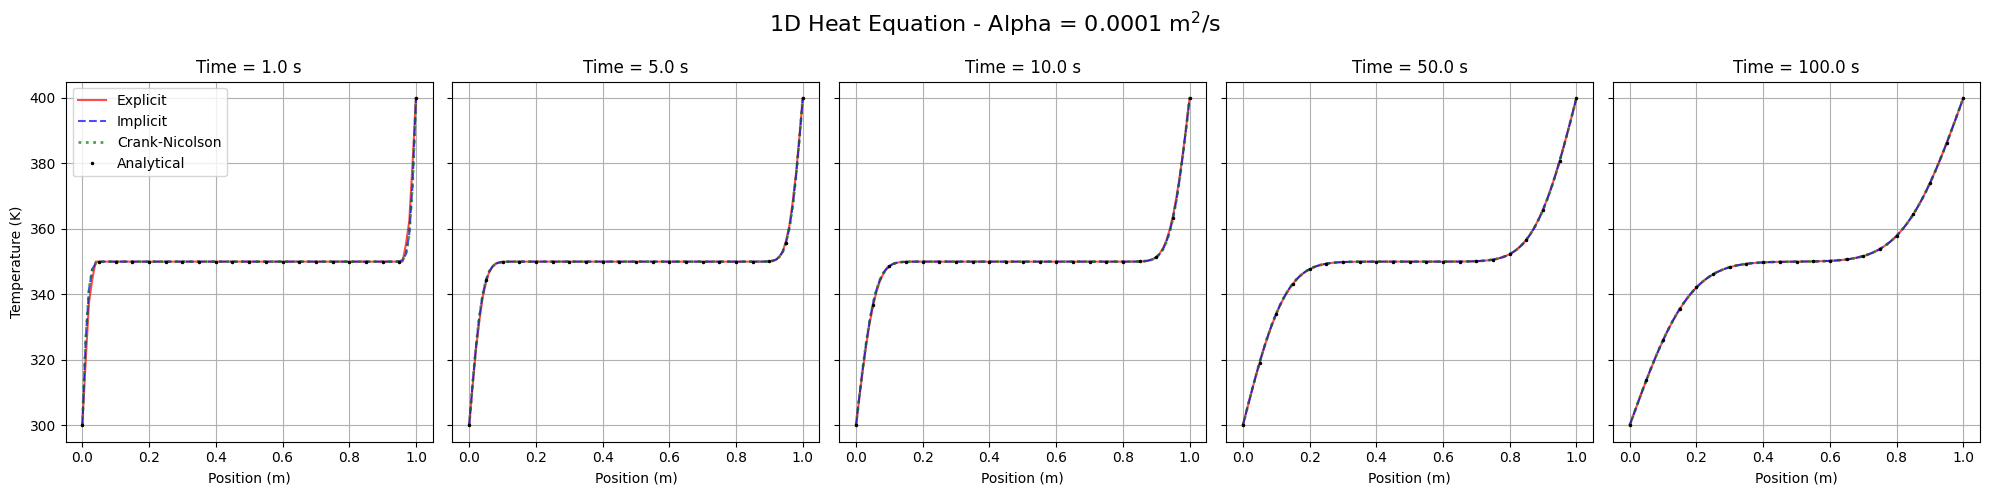

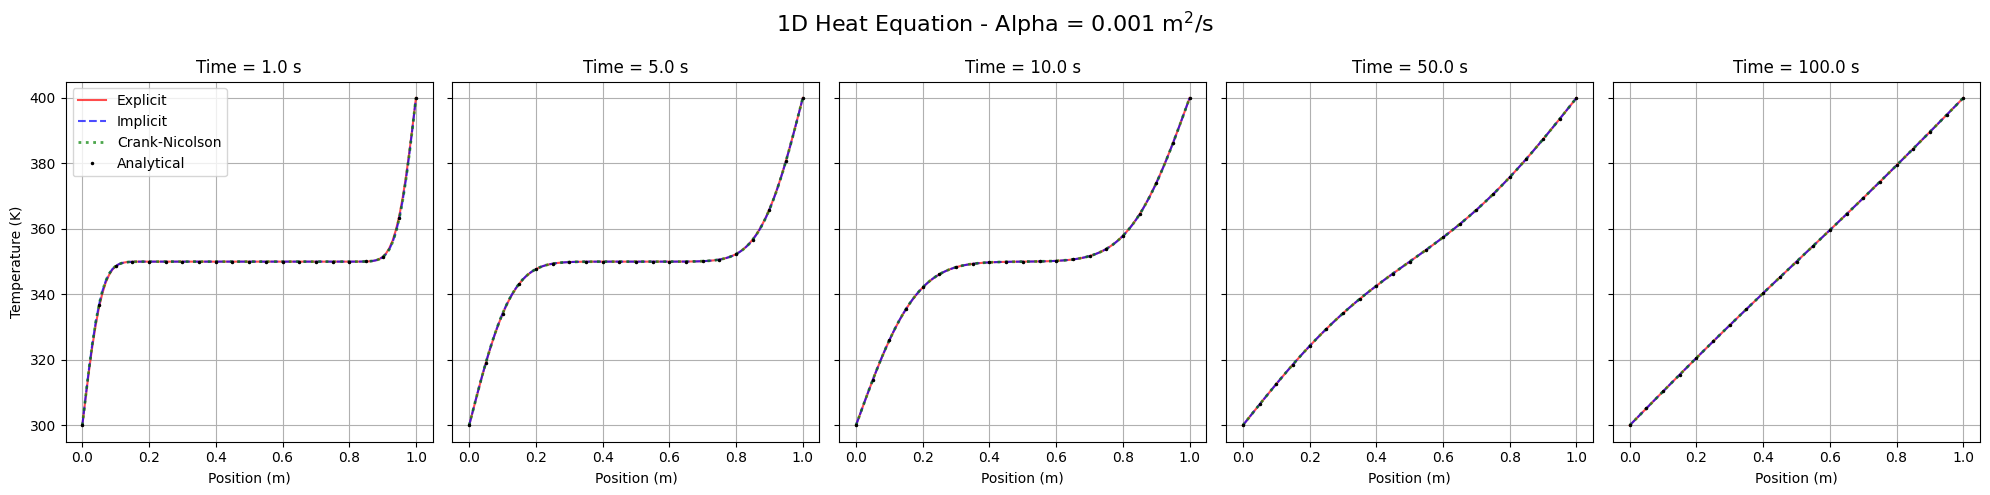

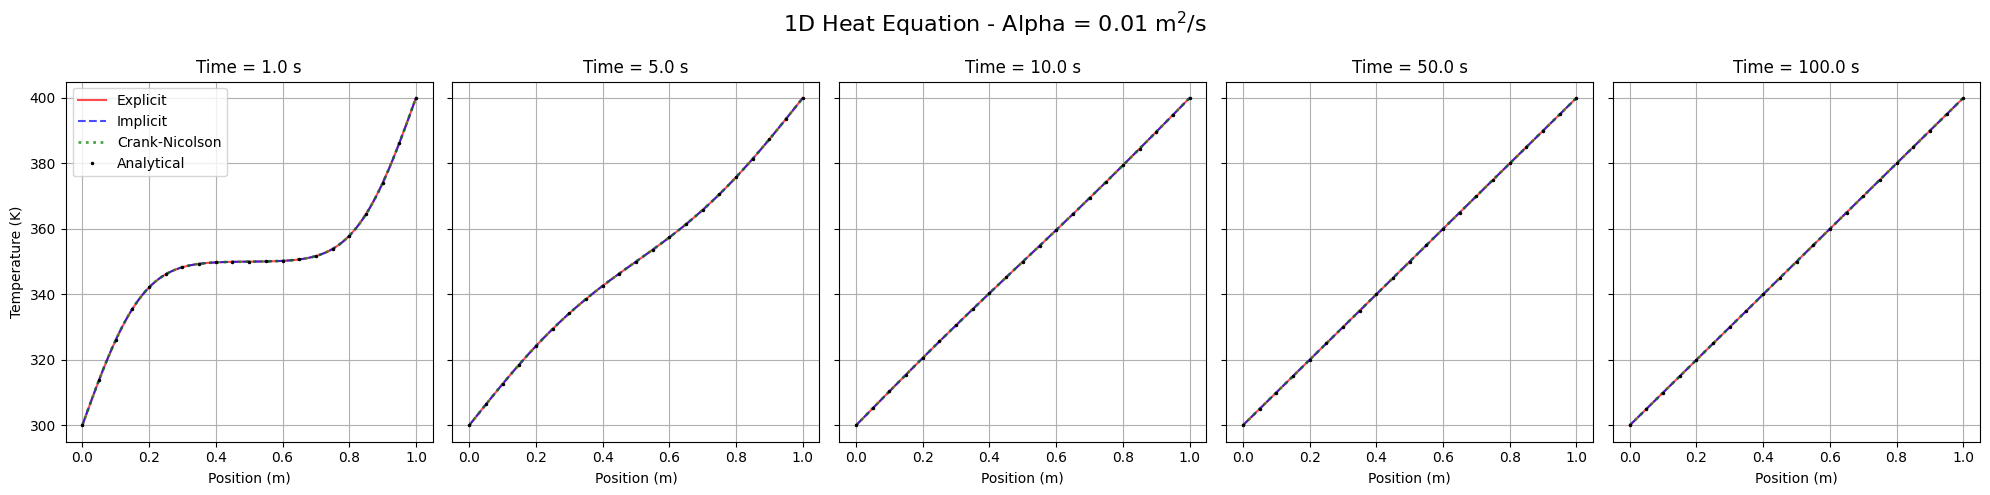

In [2]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import time

# --- Configurations ---
L = 1.0           # Length of the slab (m)
T_initial = 350.0 # Initial Temperature (K)s
T_left = 300.0    # Boundary Condition at x=0 (K)
T_right = 400.0   # Boundary Condition at x=L (K)
dx = 0.01         # Spatial step size (m)
alpha_values = [0.0001, 0.001, 0.01] # Thermal Diffusivity (m^2/s)
check_times = [1.0, 5.0, 10.0, 50.0, 100.0] # Times to capture (s)

# Grid
x = np.arange(0, L + dx, dx)
Nx = len(x)

def analytical_solution(x_grid, t, alpha, N_terms=100):
    T_ss = T_left + (T_right - T_left) * x_grid / L
    v = np.zeros_like(x_grid)
    for n in range(1, N_terms + 1):
        kn = n * np.pi / L
        term1 = (-50.0 / kn) * (np.cos(n * np.pi) - 1.0)
        term2 = -100.0 * ( (-L / kn * np.cos(n * np.pi)) )
        Bn = (2.0 / L) * (term1 + term2)
        v += Bn * np.sin(kn * x_grid) * np.exp(-alpha * kn**2 * t)
    return T_ss + v

def solve_explicit(alpha, dt, check_times):
    r = alpha * dt / dx**2
    print(f"  Explicit: dt={dt:.2e}, r={r:.4f}")

    T = np.full(Nx, T_initial)
    T[0] = T_left
    T[-1] = T_right

    results = {}
    current_time = 0.0
    sorted_times = sorted(check_times)
    next_check_idx = 0

    # Preallocate arrays to avoid creation in loop
    T_new = np.empty_like(T)

    step = 0
    steady_state_tol = 1e-6

    while next_check_idx < len(sorted_times):
        target_time = sorted_times[next_check_idx]

        # Check if we are at or passed target time
        if current_time >= target_time:
            # Linear interpolation if needed, or just take nearest.
            # Given small dt, nearest is fine.
            results[target_time] = T.copy()
            next_check_idx += 1
            continue

        # Optimization: Check for steady state every 1000 steps
        if step % 1000 == 0 and step > 0:
            # Simple check: if max change is tiny
            # Note: explicit change per step is T_new - T
            # (T_new - T) / dt approx dT/dt. If dT/dt ~ 0 -> steady.
            pass # Implement below inside loop for correctness

        # Compute next step
        # T_new[1:-1] = r*T[0:-2] + (1-2r)*T[1:-1] + r*T[2:]
        # Optimized:
        T_new[1:-1] = T[1:-1] + r * (T[0:-2] - 2*T[1:-1] + T[2:])
        T_new[0] = T_left
        T_new[-1] = T_right

        # Check convergence
        max_diff = np.max(np.abs(T_new - T))
        if max_diff < steady_state_tol * dt: # Scale by dt to approximate time derivative
             # Steady state reached
             print(f"  Explicit reached steady state at t={current_time:.4f}")
             # Fill remaining times
             while next_check_idx < len(sorted_times):
                 results[sorted_times[next_check_idx]] = T_new.copy()
                 next_check_idx += 1
             break

        T[:] = T_new[:]
        current_time += dt
        step += 1

    return results

def solve_implicit(alpha, dt, check_times):
    r = alpha * dt / dx**2
    print(f"  Implicit: dt={dt:.2e}, r={r:.4f}")

    T = np.full(Nx, T_initial)
    T[0] = T_left
    T[-1] = T_right

    results = {}
    current_time = 0.0
    sorted_times = sorted(check_times)
    next_check_idx = 0

    # Matrices
    M = Nx - 2
    main_diag = (1 + 2*r) * np.ones(M)
    upper_diag = -r * np.ones(M)
    lower_diag = -r * np.ones(M)
    ab = np.zeros((3, M))
    ab[0, 1:] = upper_diag[:-1]
    ab[1, :] = main_diag
    ab[2, :-1] = lower_diag[1:]

    step = 0
    steady_state_tol = 1e-6

    while next_check_idx < len(sorted_times):
        target_time = sorted_times[next_check_idx]

        if current_time >= target_time:
            results[target_time] = T.copy()
            next_check_idx += 1
            continue

        b = T[1:-1].copy()
        b[0] += r * T_left
        b[-1] += r * T_right

        T_internal = solve_banded((1, 1), ab, b)

        # Convergence check
        diff = np.max(np.abs(T_internal - T[1:-1]))
        if diff < steady_state_tol * dt:
            print(f"  Implicit reached steady state at t={current_time:.4f}")
            while next_check_idx < len(sorted_times):
                 results[sorted_times[next_check_idx]] = T.copy() # Use current T
                 next_check_idx += 1
            break

        T[1:-1] = T_internal
        current_time += dt
        step += 1

    return results

def solve_crank_nicolson(alpha, dt, check_times):
    r = alpha * dt / dx**2
    print(f"  CN: dt={dt:.2e}, r={r:.4f}")

    T = np.full(Nx, T_initial)
    T[0] = T_left
    T[-1] = T_right

    results = {}
    current_time = 0.0
    sorted_times = sorted(check_times)
    next_check_idx = 0

    M = Nx - 2
    main_diag_L = (1 + r) * np.ones(M)
    upper_diag_L = -0.5 * r * np.ones(M)
    lower_diag_L = -0.5 * r * np.ones(M)
    ab = np.zeros((3, M))
    ab[0, 1:] = upper_diag_L[:-1]
    ab[1, :] = main_diag_L
    ab[2, :-1] = lower_diag_L[1:]

    step = 0
    steady_state_tol = 1e-6

    while next_check_idx < len(sorted_times):
        target_time = sorted_times[next_check_idx]

        if current_time >= target_time:
            results[target_time] = T.copy()
            next_check_idx += 1
            continue

        # RHS
        b = 0.5 * r * T[0:-2] + (1 - r) * T[1:-1] + 0.5 * r * T[2:]
        b[0] += 0.5 * r * T_left
        b[-1] += 0.5 * r * T_right

        T_internal = solve_banded((1, 1), ab, b)

        diff = np.max(np.abs(T_internal - T[1:-1]))
        if diff < steady_state_tol * dt:
            print(f"  CN reached steady state at t={current_time:.4f}")
            while next_check_idx < len(sorted_times):
                 results[sorted_times[next_check_idx]] = T.copy()
                 next_check_idx += 1
            break

        T[1:-1] = T_internal
        current_time += dt
        step += 1

    return results

# --- Main Execution ---

for alpha in alpha_values:
    print(f"\nProcessing Alpha = {alpha}")

    # Timestep determination
    dt_exp = 0.5 * dx**2 / alpha * 0.95 # Stable for explicit
    dt_imp = min(0.01, dt_exp * 10) # Implicit can use larger dt, but let's keep it reasonable
    # For alpha=100, dt_exp ~ 5e-7. impl dt ~ 5e-6? Still slow.
    # Let's set a distinct dt for implicit/CN that is "stable enough" and fast.
    # Typically implicit can handle r >> 0.5. Let's aim for r=1.0 or r=2.0 for implicit?
    # Or just fixed dt?

    # For fair comparison in "results", we should use a good dt.
    # But for alpha=100, user probably wants to see functionality.
    # Let's use dt_exp for Explicit, and slightly larger for others.

    # Override for High Alpha to avoid infinite wait if SS not detected
    if alpha == 100:
       dt_imp = 0.0001 # r = 100 * 1e-4 / 1e-4 = 100. Stable for implicit.
       # dt_exp must be 5e-7.
    elif alpha == 10:
       dt_imp = 0.001
    else:
       dt_imp = 0.005 # r = 1 * 0.005 / 1e-4 = 50.

    # Solve
    t0 = time.time()
    res_exp = solve_explicit(alpha, dt_exp, check_times)
    print(f"  Explicit done in {time.time()-t0:.2f}s")

    t0 = time.time()
    res_imp = solve_implicit(alpha, dt_imp, check_times)
    print(f"  Implicit done in {time.time()-t0:.2f}s")

    t0 = time.time()
    res_cn = solve_crank_nicolson(alpha, dt_imp, check_times)
    print(f"  CN done in {time.time()-t0:.2f}s")

    # Plotting
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
    fig.suptitle(f"1D Heat Equation - Alpha = {alpha} m$^2$/s", fontsize=16)

    for i, t_check in enumerate(check_times):
        ax = axes[i]

        # Get data (or last available)
        # Assuming solvers returned dict with keys matching check_times
        # If check_times weren't hit exactly inside solver due to SS exit,
        # the filler logic should cover it.

        # Use simple tolerance for float keys
        def get_res(res, t):
            # find key close to t
            for k in res:
                if abs(k - t) < 1e-9: return res[k]
            return res[list(res.keys())[-1]] # Fallback

        Y_exp = get_res(res_exp, t_check)
        Y_imp = get_res(res_imp, t_check)
        Y_cn = get_res(res_cn, t_check)
        Y_ana = analytical_solution(x, t_check, alpha)

        ax.plot(x, Y_exp, 'r-', label='Explicit', alpha=0.7)
        ax.plot(x, Y_imp, 'b--', label='Implicit', alpha=0.7)
        ax.plot(x, Y_cn, 'g:', label='Crank-Nicolson', linewidth=2, alpha=0.7)
        ax.plot(x, Y_ana, 'k.', label='Analytical', markersize=3, markevery=5)

        ax.set_title(f"Time = {t_check} s")
        ax.set_xlabel("Position (m)")
        if i == 0:
            ax.set_ylabel("Temperature (K)")
            ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(f"heat_eq_alpha_{int(alpha)}.png", dpi=300)
    print(f"Saved plot: heat_eq_alpha_{int(alpha)}.png")

print("All simulations complete.")